# **Estruturas criptográficas 2024-2025**
**Grupo 02**

**Pg55986:** Miguel Ângelo Martins Guimarães 

**Pg55997:** Pedro Miguel Oliveira Carvalho 

Universidade do Minho, Março 2025

***
# **Exercicio 3b**

### **Enunciado do exercicio:**

**Enunciado:** Construa uma implementação em curvas elípticas de um protocolo autenticado de “Oblivious Transfer” k-out-of-n.

Para a realização deste exercicio reaproveitamos o codigo desenvolvido no exercicio anterior, mais concretamente o **ElGamal** *CPA* implementado utilizando curvas elipticas.

**Contexto Criptográfico:** Ao utilizar curvas elípticas, a implementação irá utilizar chaves menores e as operações são mais eficientes. Esta abordagem é diferente da versão tradicional como a que foi implementada no exercicio **ex1d.sage** que utiliza o esquema *ElGamal* baseado em aritmética modular.


## **Utilização de curvas de edwards**  
  Neste relatorio o exercicio 1D será utilizado como comparação uma vez que ambos implementam um protocolo autenticado de "Oblivious Transfer" k-out-of-n, onde a unica diferença é a utilização da curva de edwards.
  
  A implementação trabalha com um grupo formado pelos pontos de uma **curva elíptica**, onde as operações fundamentais são a **adição** de pontos e a **multiplicação** escalar.
  Este métodos substituem as operações de **exponenciação** e **inversão** modular que foram utilizadas na versão "normal" do protocolo.

## **Setup do protocolo**
Para a execução do protocolo, utilizamos os seguintes parâmetros:

**n:** número total de mensagens disponíveis.

**k:** número de mensagens que o recetor deseja obter.

**Edwards25519:** curva elíptica de edwards que foi escolhida na implementação deste protocolo.

***
## **Criação da matriz A**

A matriz A irá ter uma dimensão de ```n * (n - k)```. Relembro que o valor **k** é o numero de mensagens que o recetor deseja receber e **n** é o numero total de mensagens disponiveis.

Os valores da matriz são gerados passando a concatenação da seed(rho) com os indices **i**,**j** e uma posterior aplicação da função de hash **SHA-256** (que foi implementado utilizando a hashlib), o valor resultante da aplicação da função de *hash* é utilizado para obter um valor escalar que pertence ao campo finito da curva de edwards.


```py
def matrixA(curve, lines, cols, seed):
    K = curve.K
    A = matrix(K, lines, cols)
    for i in range(lines):
        for j in range(cols):
            A[i,j] = K(H(str(seed) + str(i) + str(j), length=curve.L.nbits()))
    return A
```

***
## **Criação do vetor u**
A criação do vetor **u** é semelhante á criação da matriz **A**. A diferença é que na sua geração é utilizada uma seed diferente e apenas é utilizado um unico indice.
Então, os valores da matriz são gerados passando a concatenação da seed(rho) com o indice **i** e uma posterior aplicação da função de hash **SHA-256**, o valor resultante da aplicação da função de *hash* é utilizado para obter um valor escalar que pertence ao campo finito da curva de edwards.

```py
def vectorU(curve, cols, seed):
    K = curve.K
    u = vector(K, cols)
    for i in range(cols):
        u[i] = K(H(str(seed) + str(i), length=curve.L.nbits()))
    return u
```


***
## **Oblivious criterion**
No *oblivious criterion* vamos gerar as duas seeds referidas anteriormente e vão ser criadas a matriz **A** e o vetor **u**. 

O oblivious criterion é o conjunto formado pela matriz **A** e o vetor **u** e é a estrutura centrar de todo o protocolo *oblivious transfer*.

```py
def generate_oblivious_criterion(n, kappa, curve):
    # Gerar seeds
    rho1 = os.urandom(16).hex()
    rho2 = os.urandom(16).hex()
    
    # Criar a matriz A e vetor u
    A = matrixA(curve, n, n-kappa, rho1)
    u = vectorU(curve, n-kappa, rho2)
    
    return A, u, (rho1, rho2)
```

***
## **Compute Good Keys**
Para cada mensagem que é escolhida pelo recetor é necessário criar um par de chaves **publica e privada**. A chave publica vai ser utilizada para cifrar as mensagens escolhidas enquanto que a chave privada vai ser utilizada para decifrar essas mesmas mensagens. As **chaves publicas** geradas são guardadas em um **vetor p_vector** nas posições correspondentes às mensagens escolhidas.

Os pares gerados em si são guardados no dicionario **good_keys**. 

É também gerada uma tag de autenticação com base nos indices escolhidos e numa chave secreta aleatoria (o secret).
Esta **tag** garante a integridade dos indices escolhidos permitindo verificar se os indices foram manipulados, isto porque um *man-in-the-middle*, por exemplo, poderá alterar os indices escolhidos para outros da sua escolha e realizar um possivel ataque.

```py
def compute_goodKeys(selected_indices, n, edwards_elgamal):
    p_vector = [None] * n   # Vetor que guarda as chaves publicas
    good_keys = {}          # Vetor que armazena os pares de chaves gerados
    
    # Para cada índice selecionado vai ser gerado um par de chaves
    for i in selected_indices:
        public_key, private_key = edwards_elgamal.keygen()
        good_keys[i] = (public_key, private_key)
        p_vector[i] = public_key
    
    # Gerar tag para verificação
    secret = os.urandom(edwards_elgamal.lambda_security // 8)
    indices_bytes = b"".join([i.to_bytes(4, 'big') for i in selected_indices])
    tag = hashlib.sha256(indices_bytes + secret).digest()
```

***
## **Compute P vector**
Com a função que iremos apresentar a seguir são preenchidas as posições vazias do vetor **p_vector** (vetor publico referido na etapa anterior), estas posições vazias resultam de não terem sido escolhidas pelo recetor.

Para preencher este vetor é resolvido o sistema: ```A*x=u```, o **vetor x** possui as posições escolhidas, as posições restantes que não se encontram preenchidas são obtidas resolvendo este sistema.
O vetor **p** fica então preenchido com os seguintes valores:

- **Índices escolhidos:** chaves públicas.

- **Índices não escolhidos:** valores obtidos pela resolução do sistema linear.


**Clarificação:** Na implementação no codigo é obtido um **vetor R** e um **vetor B**, o **vetor B** é uma matriz que contem as linhas não escolhidas do **vetor A**, já o **vetor R** é um vetor que utiliza os valores das posições escolhidas pelo recetor. Assim é desejado resolver o sistema ```B*X=R```. 

```py
# Completa o vetor p com pontos para os índices não selecionados
def complete_p_vector(curve, A, u, selected_indices, p_vector):
    n = A.nrows()
    K = curve.K
    
    all_indices = set(range(n))
    unselected_indices = sorted(list(all_indices - set(selected_indices)))
    
    # Criar o vetor R baseado nos pontos já escolhidos
    R = vector(K, u)
    for i in selected_indices:
        if p_vector[i] is not None:
            x_coord = p_vector[i].x
            row = vector(K, A[i])
            R -= x_coord * row
            
    # Criar matriz B para resolver o sistema
    B_rows = [vector(K, A[j]) for j in unselected_indices]
    B = matrix(K, B_rows)
    
    # Resolver o sistema
    B_inv = B.inverse()
    X = R * B_inv
    
    # Atribuir pontos para índices não selecionados
    for idx, j in enumerate(unselected_indices):
        # Criar um ponto que corresponde ao valor calculado
        x_val = X[idx]
        point = generate_point_with_x(curve, x_val)
        p_vector[j] = point
        
    return p_vector
```

***
## **Generate Point with X**
A função *generate_point_with_x* serve para obter um ponto na curva de **Edwards** a partir de uma coordenada x conhecida, este ponto deverá conter um valor de x proximo ao desejado.

O funcionamento passa por utilizar o valor inicial de **x** fornecido e combinar com uma função hash para gerar diferentes candidatos que pertencem ao campo finito da curva.

Para cada candidato vamos verificar se este pode ser utilizado como coordenada **x** em um ponto valido da curva.

Esta verificação é feita atraves da equação da curva de curva eliptica ```y^2 = x^3 + a4*x + a6```.

Então na implementação desta parte simplesmente vamos iterar todos os candidatos e calculando os valores de ```f(x) = x^3 + a4*x + a6```

Assim que o valor de **f(x)** for um quadrado perfeito isso significa que conseguimos calcular a raiz do **f(x)** (que é o mesmo que y^2) para obter o valor de **y**.

Com este processo acabamos por conseguir gerar, ou não, um ponto na curva de edwards com uma coordenada **x** proxima á desejada e o seu valor de **y** correspondente.


```py
# Gera um ponto com uma coordenada x aproximada
def generate_point_with_x(curve, x_val):
    """Gera um ponto com coordenada x aproximada"""
    hash_input = str(x_val)
    for i in range(100): # Tentar 100 valores diferentes
        candidate_x = curve.K(H(hash_input + str(i), length=curve.L.nbits()))
        try:
            # Verificar se pode ser coordenada x de um ponto
            f_val = curve.K(candidate_x**3 + curve.constants['a4']*candidate_x + curve.constants['a6'])
            if f_val.is_square():
                y = f_val.sqrt()
                ec_point = curve.EC(candidate_x, y)
                ed_x, ed_y = curve.ec2ed(ec_point)

                # Armazenar o valor original para verificação
                point = EdPoint(ed_x, ed_y, curve)
                point.original_x = x_val  # adicionar atributo para verificação
                
                return point
        except:
            continue
    
    raise ValueError("Não foi possível encontrar um ponto com coordenada x próxima ao desejado")
```

***
## **Generate query vector**
O query vector é um vetor que o recetor utiliza para interagir com o remetente no protocolo. Este vetor codifica as escolhas do recetor e é usado para garantir que ele consiga recuperar exatamente 
k mensagens sem revelar quais escolheu.

Na implementação deste query vector nos inicializamos um vetor vazio de tamanho **n**.

Para cada indice escolhido é gerada uma chave utilizando a função ```compute_goodKeys``` que já foi explicada anteriormente.

Depois é preenchido o vetor p com a função ```complete_p_vector``` que preenche as posições que não foram escolhidas pelo recetor resolvendo um sistema tal como já foi explicado anteriormente.

```py
# Gera o vetor de consulta para o protocolo OT
def generate_query_vector(A, u, selected_indices, edwards_elgamal):
    n, n_minus_kappa = A.dimensions()
    kappa = n - n_minus_kappa
    
    if len(selected_indices) != kappa:
        raise ValueError(f"O receiver deve escolher exatamente {kappa} índices")
    
    # Gerar chaves para índices selecionados
    curve = edwards_elgamal.curve
    good_keys, tag, p_vector, secret = compute_goodKeys(selected_indices, n, edwards_elgamal)
    
    # Completar o vetor p para índices não selecionados
    p_vector = complete_p_vector(curve, A, u, selected_indices, p_vector)
    
    return p_vector, tag, good_keys
```


***
## **Verify criterion**
A função ```verify_criterion``` é importante uma vez que garante que o vetor de consulta gerado. **Nota:** Relembro que este vetor foi gerado na função ```generate_query_vector```.

É inicializado um vetor vazio total que será utilizado para verificar se a equação ```A*p_vector = u``` é verdadeira.

Todas as posições de p_vector são percorridas e para cada uma delas é calculado o valor de total.

No final verificamos se o valor obtido é equivalente ao valor de **u**, o que indica que o **p_vector** é valido.

```py
# Verifica o vetor de consulta
def verify_criterion(p_vector, A, u, curve):
    K = curve.K
    n = len(p_vector)
    d = len(u)
    
    total = vector(K, [0] * d)
    for i in range(n):
        row = vector(K, A[i])
        # Usar o valor original para verificação
        x_val = getattr(p_vector[i], 'original_x', p_vector[i].x)
        total += K(x_val) * row
        
    u_vec = vector(K, u)
    return total == u_vec
```

***
## **Encrypt messages**
É crucial ao **protocolo** que a cifrarem de mensagens seja realizada, para isso foi utilizado o *elGamal* tal como no exercicio 1d. No entanto o *elGamal* utilizado é que foi construido para o exercicio 3a, ou seja, é o *elGamal* implementado recorrendo a curvas de edwards.

Esta função é relativamente simples, todo o processo baseia-se em **cifrar todas as mensagens** utilizando do *elGamal sobre curvas elipticas*, é tambem gerada uma **tag** que garante a **integridade** dos dados que foram cifrados, impedindo alguem de os modificar.

```py

# Cifrar as mensagens utilizando o ElGamal com curvas de Edwards
def encrypt_messages(messages, A, u, query_vector, tag, edwards_elgamal):
    encrypted_messages = []
    
    for i in range(len(messages)):
        try:
            # A chave pública para este índice é o elemento do query_vector
            public_key = query_vector[i]
            
            # Cifrar mensagem utilizando o ElGamal em curvas de Edwards
            encrypted_data = edwards_elgamal.encrypt_message(public_key, messages[i])
            
            # Gerar hash para garantir a integridade, utilizando a tag
            c_2 = H(str(encrypted_data) + str(tag.hex()))
            
            encrypted_messages.append({
                'index': i,
                'ciphertext': (encrypted_data, c_2)
            })
            
        except Exception as e:
            print(f"Erro ao cifrar mensagem {i}: {e}")
    
    return encrypted_messages
```

***
## **Decrypt messages**

A função ```decrypt_messages``` é responsável por decifrar as mensagens cifradas utilizando o esquema **ElGamal** em curvas de Edwards.

Nesta implementação iremos percorrer todas as mensagens **cifradas** e obtemos a chave que foi utilizada na cifragem recorrendo ao vetor **good_keys**, para verificar a integridade dos dados comparamos o hash calculado com o hash recebido, se forem equivalentes então o conteudo não foi alterado.

Ocorre posteriormente uma decifrarem do conteudo e depois armazenamos os dados decifrados num dicionario, obtendo assim apenas as mensagens escolhidas.

``` py
# Decifrar as mensagens utilizando elGamal edwards
def decrypt_messages(encrypted_messages, selected_indices, good_keys, tag, edwards_elgamal):
    decrypted_messages = {}
    
    for message_data in encrypted_messages:
        i = message_data['index']
        
        """if i not in selected_indices:
            print(f"Mensagem {i}: não selecionada, ignorando")
            continue"""
            
        try:
            ciphertext = message_data['ciphertext']
            encrypted_data, c_2 = ciphertext
            
            # Chave privada para este índice
            _, private_key = good_keys[i]
            
            # Verificar integridade com tag
            c_2_calculated = H(str(encrypted_data) + str(tag.hex()))
            
            if c_2_calculated != c_2:
                print(f"  Mensagem {i}: falha na verificação de integridade")
                continue
                
            # Decifrar mensagem
            plaintext = edwards_elgamal.decrypt_message(private_key, encrypted_data)
            
            decrypted_messages[i] = plaintext
            print(f"  Mensagem {i} decifrada: {plaintext}")
            
        except Exception as e:
            print(f"Não foi possível decifrar mensagem {i}: {e}")
    
    return decrypted_messages
```

***

# **Testes**

Aqui encontra-se um teste realizado para um numero total de 30 mensagens em que se quer receber 13 mensagens. 

O codigo que implementa esta secção encontra-se na função **Main**.

#### Inputs
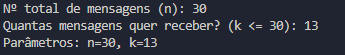

#### Configuração
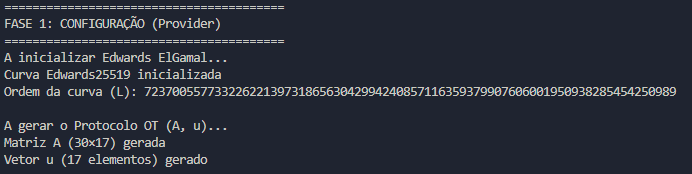

#### Seleção de mensagens (aleatoria)
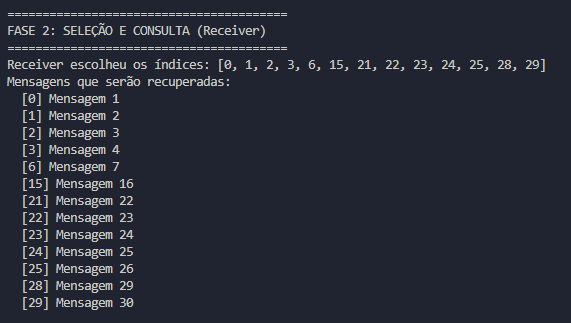

#### Cifragem de mensagens
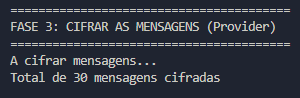

#### Decifragem de mensagens
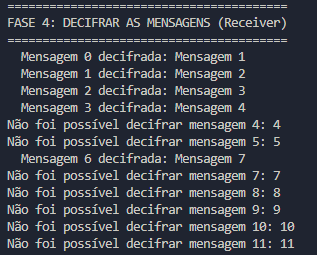

Como se pode verificar não foi possivel decifrar as mensagens que não foram escolhidas!

#### Resultado final
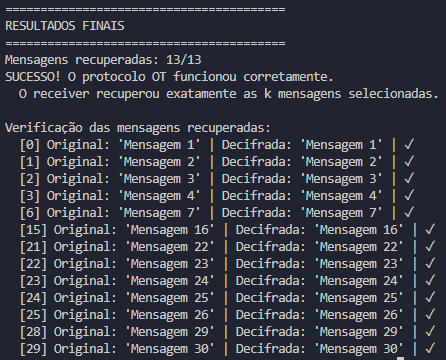

Obtivemos o resultado desejado em que apenas as mensagens escolhidas foram decifradas!